# Part 9: Frame Grabbers and Advanced hls4ml Features

## Table of Contents
- Helpful functions for dataset
- Helpful functions for training
- Make dataset
- Model training
    - QKeras model classification performance
- Hardware optimization API for pattern pruning
- Extensions API for custom layer
- Post-training quantization, compiling an hls4ml model
- HLS model profiling
- Simulate HLS model
    - HLS model classification performance
- FIFO Optimization
- Frame grabber firmware integration
    - Acquisition parameters, network weights, layers, and other
    - C-simulation
    - Frame grabber model classification performance
    - C-synthesis
    - Implementation
    - Optional: Benchmarking
- Conclusion

This tutorial will cover the quantization-aware training and deployment of YOLO-type neural networks to high-speed frame grabbers, specifically the Euresys Coaxlink Octo, Quad CXP-12, and QSFP+. It also covers the post-training quantization process, Hardware Optimization API, Extensions API, HLS model profiling, and FIFO optimization features of hls4ml.

**IMPORTANT:** Be sure to activate ```hls4ml_frame_grabber``` conda environment (see README for instructions on installing).

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shutil

import hls4ml
from hls4ml.model.profiling import numerical

import tensorflow as tf
from tensorflow.keras import layers, activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, Activation, Flatten, AveragePooling2D, MaxPool2D, Concatenate, Input
from tensorflow.keras.models import Model

from qkeras.qlayers import QDense, QActivation
from qkeras.qconvolutional import QConv2D
from qkeras.qpooling import QAveragePooling2D
from qkeras.quantizers import quantized_bits, quantized_relu, smooth_sigmoid

from sklearn.model_selection import train_test_split

2024-08-07 17:00:29.881088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rff224/miniforge3/envs/hls4ml_frame_grabber/lib/python3.8/site-packages/cv2/../../lib64:/opt/xilinx/xrt/lib
2024-08-07 17:00:29.881138: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Helpful functions for dataset

This fake YOLO (FOLO) will have non-standard small pure CNN architecture suitable for deployment to more resource-constrained FPGA devices such these frame grabbers which come equipped with an Xilinx KU035. The dataset will consist of 128x48 frames with MNIST digits randomly inserted throughout. This model and code is adapted from Seachaos' Medium article [here](https://tree.rocks/a-simple-way-to-understand-and-implement-object-detection-from-scratch-by-pure-cnn-36cc28143ca8).

In [2]:
grid_size = 16  # image_size / mask_size
threshold = 0.9

def make_numbers(X, y): 
    """
    Generates a new data sample by placing random MNIST digits around a 128x48 frame
    
    :param X: New empty FOLO data array
    :param y: New empty FOLO labels data array
    """
    
    for _ in range(3): # place three digits around the image
        
        idx = np.random.randint(len(X_num)) # pick a random digit to insert in frame 
        number = X_num[idx] # grab digit
        kls = y_num[idx]    # grab class
        
        px, py = np.random.randint(0, 100), np.random.randint(0, 20) # generate a random position for the digit
        
        mx, my = (px+14) // grid_size, (py+14) // grid_size # calculate which mask region the digit will belong to
        channels = y[my][mx]

        # prevent duplicates
        if channels[0] > 0:
            continue
            
        channels[0] = 1.0
        channels[1] = px - (mx * grid_size)  # x1
        channels[2] = py - (my * grid_size)  # y1
        channels[3] = 28.0                   # x2
        channels[4] = 28.0                   # y2
        channels[5 + kls] = 1.0
        
        # Insert digit to frame
        X[py:py+28, px:px+28] += number
        
def make_data(size=64):
    """
    Generates a new dataset for FOLO training
    
    :param size: Number of samples to generate for training, can be larger than MNIST dataset
    :return: New dataset and labels
    """

    X = np.zeros((size, 48, 128, 1), dtype=np.float32)  # New data sample of 128x48 images
    y = np.zeros((size, 3, 8, 15), dtype=np.float32)    # New data output consists of probability, bounding box, and class
    
    # Generate data
    for i in range(size): 
        make_numbers(X[i], y[i])
        
    X = np.clip(X, 0.0, 1.0)
    return X, y

def show_predict(X, y, threshold=0.1):
    """
    Display single prediction results
    
    :param X: Data sample input
    :param y: Model predictions
    :param threshold: Probability threshold    
    """
    
    X = X.copy()
    for mx in range(8):
        for my in range(3):
            channels = y[my][mx]
            prob, x1, y1, x2, y2 = channels[:5]

            # if prob < threshold we won't show any thing
            if prob < threshold:
                continue
                                
            color = 255
            # bounding box
            px, py = (mx * grid_size) + x1, (my * grid_size) + y1
            cv2.rectangle(X, (int(px), int(py)), (int(px + x2), int(py + y2)), -1, 1)
            
            # label
            cv2.rectangle(X, (int(px), int(py - 10)), (int(px + 12), int(py)), -1, -1)
            kls = np.argmax(channels[5:])
            cv2.putText(X, f'{kls}', (int(px + 2), int(py-2)), cv2.FONT_HERSHEY_PLAIN, 0.7, (0.0, 0.0, 0.0))

            print("digit: " + str(np.argmax(channels[5:15])) + ", prob: " + str(prob) + ", x1: " + str(int(px)) + ", y1: " + str(int(py)) + ", x2: " + str(int(px + x2)) + ", y2: " + str(int(py + y2)))
            
    plt.imshow(X, cmap="gray")

def eval_model_cls_performance(y_pred, y):

    y_pred_flattened = y_pred.reshape(-1, 15)
    filtered_indices = y_pred_flattened[:, 0] > threshold
    filtered_y_pred = y_pred_flattened[filtered_indices]
    filtered_y = y.reshape(-1, 15)[filtered_indices]

    predicted_labels_y_pred = np.argmax(filtered_y_pred[:, 5:15], axis=1)
    predicted_labels_y = np.argmax(filtered_y[:, 5:15], axis=1)

    return predicted_labels_y_pred, predicted_labels_y    


## Helpful functions for training

In [3]:
idx_p = [0] # probability
idx_bb = [1, 2, 3, 4] # bounding box
idx_cls = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14] # class
batch_size = 32
epochs = 30

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

## Make dataset

In [4]:
(X_num, y_num), _ = tf.keras.datasets.mnist.load_data()
X_num = np.expand_dims(X_num, axis=-1).astype(np.float32) / 255.0

Let's take a quick look at our data.

digit: 6, prob: 1.0, x1: 24, y1: 18, x2: 52, y2: 46
digit: 6, prob: 1.0, x1: 50, y1: 11, x2: 78, y2: 39


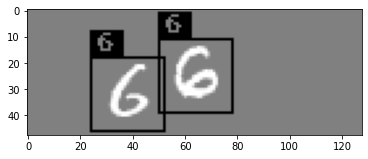

In [5]:
X, y = make_data(size=batch_size * 1000)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

show_predict(X_test[0], y_test[0])

## Model training

In [6]:
def FOLO_conv():
    """
    FOLO model architecture using standard qkeras layers.

    :return: qkeras model
    """
    
    tf.compat.v1.reset_default_graph()
    x = inputs = Input(shape=(48, 128, 1), name='input_1')

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,4,alpha=1), bias_quantizer=quantized_bits(8,3,alpha=1), kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(18,5,alpha=1), bias_quantizer=quantized_bits(15,4,alpha=1), kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,3,alpha=1), bias_quantizer=quantized_bits(9,2,alpha=1), kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(18,5,alpha=1), bias_quantizer=quantized_bits(12,5,alpha=1), kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)
    
    x_prob = QConv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid', kernel_quantizer=quantized_bits(13,3,alpha=1), bias_quantizer=quantized_bits(5,3,alpha=1), kernel_initializer='lecun_uniform')(x)
    x_boxes = QConv2D(4, kernel_size=3, padding='same', name='x_boxes', kernel_quantizer=quantized_bits(19,5,alpha=1), bias_quantizer=quantized_bits(7,5,alpha=1), kernel_initializer='lecun_uniform')(x)
    x_cls = QConv2D(10, kernel_size=3, padding='same', name='x_cls', activation='sigmoid', kernel_quantizer=quantized_bits(21,5,alpha=1), bias_quantizer=quantized_bits(7,3,alpha=1), kernel_initializer='lecun_uniform')(x)
    
    gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
    x_boxes = x_boxes * gate
    x_cls = x_cls * gate
    
    x = Concatenate()([x_prob, x_boxes])
    x = Concatenate()([x, x_cls])
   
    model = Model(inputs, x)
    return model

In [7]:
model = FOLO_conv()
model.summary()

2024-08-07 17:00:35.743469: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-07 17:00:35.743500: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gw001): /proc/driver/nvidia/version does not exist
2024-08-07 17:00:35.743847: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 q_conv2d (QConv2D)             (None, 48, 128, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 64, 16)   0           ['q_conv2d[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 64, 16)  64          ['max_pooling2d[0][0]']      

In [8]:
model.compile(loss=loss_func, optimizer=opt)

In [9]:
# # Uncomment below to enable training
# model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

In [10]:
# model.save_weights('weights/folo_weights_qat.h5')
model.load_weights('weights/folo_weights_qat.h5') # Load if you would like to skip training

### QKeras model classification performance

Lets get an idea of how the model is performing. We expect this model to perform worse than standard MNIST classifiers as digits are allowed to overlap and are more likely to do so at lower resolutions in cases such as this.

digit: 6, prob: 0.9563567, x1: 24, y1: 19, x2: 50, y2: 44
digit: 6, prob: 0.9055729, x1: 46, y1: 12, x2: 70, y2: 36


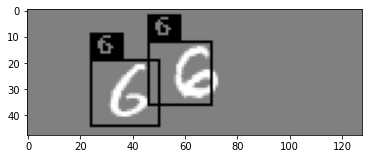

In [11]:
keras_y_pred = model.predict(X_test[0:100])
show_predict(X_test[0], keras_y_pred[0], threshold=threshold)

In [12]:
keras_y_pred_ex, y_ex = eval_model_cls_performance(keras_y_pred, y_test[0:100])
FOLO_accuracy_keras = np.mean(keras_y_pred_ex == y_ex) * 100
print(f'FOLO classification accuracy on subset: {FOLO_accuracy_keras:.2f}%')

FOLO classification accuracy on subset: 82.40%


## Hardware optimization API for pattern pruning

We will take advantage of a number of the advanced features that hls4ml provides. First, we will use the optimization API to prune our model slightly for the benefit of a small DSP resource reduction. This improves timing and is a good demonstration of how this advanced feature can help reach a final implementation that achieves timing closure. Note that the additional training is done two sections later as an hls4ml configuration must be defined beforehand.

In [13]:
from hls4ml.optimization import optimize_keras_model_for_hls4ml
from hls4ml.optimization.attributes import get_attributes_from_keras_model
from hls4ml.optimization.keras import optimize_model
from hls4ml.optimization.keras.utils import get_model_sparsity
from hls4ml.optimization.objectives import ParameterEstimator
from hls4ml.optimization.objectives.vivado_objectives import VivadoDSPEstimator
from hls4ml.optimization.scheduler import PolynomialScheduler

In [14]:
sparsity, layers = get_model_sparsity(model)
print(f'Baseline Keras sparsity, overall: {sparsity}')
print(f'Baseline Keras sparsity, per-layer: {layers}')

Baseline Keras sparsity, overall: 0.0
Baseline Keras sparsity, per-layer: {'q_conv2d': 0.0, 'q_conv2d_1': 0.0, 'q_conv2d_2': 0.0, 'q_conv2d_3': 0.0, 'x_prob': 0.0, 'x_boxes': 0.0, 'x_cls': 0.0}


In [15]:
pr_epochs = 10
rtol = 1.6
metric, increasing = MeanSquaredError(), False

In [16]:
scheduler = PolynomialScheduler(5, final_sparsity=0.5)
model_attributes = get_attributes_from_keras_model(model)

## Extensions API for custom layer

The extensions API enables hls4ml users to implement custom layers in their model. Simply provide the HLS implementation of the layer you wish to insert to the HLS model. In this example, the custom layer we are inserting is not utilized during training but is actually for data reduction in hardware. The current model output is of shape (8,3,15) which can be reduced to twenty-four 31-bit values denoting a probability gated to a 1 or 0, four 7 and 6-bit bounding box coordinates, and a 4-bit class. The implementation for this layer is included in ``nnet_reduce.h``

In [17]:
class KReduce(tf.keras.layers.Layer):
    '''Keras implementation of custom layer'''
    
    def __init__(self):
        super().__init__()

    def call(self, inputs):
        # inputs: a tensor of shape(8,3,15)            
        return inputs[:, :, :, 0] # We want our hardware model output to be of shape (1,8,3,1)

class HReduce(hls4ml.model.layers.Layer):
    '''hls4ml implementation of custom layer'''

    def initialize(self):
        inp = self.get_input_variable()
        shape = list(inp.shape)
        shape[-1] = 1 # new output shape is (1,8,3,1)
        
        dims = ['OUT_HEIGHT_{}'.format(self.index), 'OUT_WIDTH_{}'.format(self.index), 'N_FILT_{}'.format(self.index)]
        
        self.add_output_variable(shape, dims)

def parse_reduce_layer(keras_layer, input_names, input_shapes, data_reader):
    '''Parser for converter'''
    
    layer = {}
    layer['class_name'] = 'HReduce'
    layer['name'] = keras_layer['config']['name']
    layer['n_in'] = input_shapes[0][1]*input_shapes[0][2]
    layer['grid_size'] = grid_size
    outshape = [[None, 3, 8]]

    if input_names is not None:
        layer['inputs'] = input_names

    return layer, outshape

# HLS model layer configuration
red_config_template = """struct config{index} : nnet::reduce_config {{
    static const unsigned n_in = {n_in};
    static const unsigned grid_size = {grid_size};
}};\n"""

red_function_template ='nnet::reduce<{input_t}, {output_t}, {config}>({input}, {output});'
red_include_list = ['nnet_utils/nnet_reduce.h']

class HReduceConfigTemplate(hls4ml.backends.template.LayerConfigTemplate):
    def __init__(self):
        super().__init__(HReduce)
        self.template = red_config_template

    def format(self, node):
        params = self._default_config_params(node)
        return self.template.format(**params)

class HReduceFunctionTemplate(hls4ml.backends.template.FunctionCallTemplate):
    '''New layer function template'''
    
    def __init__(self):
        super().__init__(HReduce, include_header=red_include_list)
        self.template = red_function_template

    def format(self, node):
        params = self._default_function_params(node)
        return self.template.format(**params)

# Register the converter for custom Keras layer
hls4ml.converters.register_keras_layer_handler('KReduce', parse_reduce_layer)

# Register the hls4ml's IR layer
hls4ml.model.layers.register_layer('HReduce', HReduce)

for backend_id in ['Vitis']:
    # Register the optimization passes (if any)
    backend = hls4ml.backends.get_backend(backend_id)

    # Register template passes for the given backend
    backend.register_template(HReduceConfigTemplate)
    backend.register_template(HReduceFunctionTemplate)

    # Register HLS implementation
    backend.register_source(os.path.abspath("lambda_cpp/nnet_reduce.h"))

Now define the model with the new layer and copy the weights over. This new model will not provide correct results in Python but will in hardware with the addition of the final ``reduce()`` layer

In [18]:
class quantized_relu(quantized_relu):
    ''' Workaround for quantized_relu __name__ not found bug '''
    def __init__(self, W, I):
        super(quantized_relu, self).__init__(W, I)
        self.__name__ = 'quantized_relu'


def FOLO_conv_reduce():
    """
    FOLO model architecture using standard qkeras layers.

    :return: qkeras model
    """
    
    tf.compat.v1.reset_default_graph()
    x = inputs = Input(shape=(48, 128, 1), name='input_1')

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,4,alpha=1), bias_quantizer=quantized_bits(8,3,alpha=1), kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(18,5,alpha=1), bias_quantizer=quantized_bits(15,4,alpha=1), kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,3,alpha=1), bias_quantizer=quantized_bits(9,2,alpha=1), kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(18,5,alpha=1), bias_quantizer=quantized_bits(12,5,alpha=1), kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)
    
    x_prob = QConv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid', kernel_quantizer=quantized_bits(13,3,alpha=1), bias_quantizer=quantized_bits(5,3,alpha=1), kernel_initializer='lecun_uniform')(x)
    x_boxes = QConv2D(4, kernel_size=3, padding='same', name='x_boxes', kernel_quantizer=quantized_bits(19,5,alpha=1), bias_quantizer=quantized_bits(7,5,alpha=1), kernel_initializer='lecun_uniform')(x)
    x_cls = QConv2D(10, kernel_size=3, padding='same', name='x_cls', activation='sigmoid', kernel_quantizer=quantized_bits(21,5,alpha=1), bias_quantizer=quantized_bits(7,3,alpha=1), kernel_initializer='lecun_uniform')(x)
    
    x = Concatenate()([x_prob, x_boxes])
    x = Concatenate()([x, x_cls])

    x = KReduce()(x)

    model = Model(inputs, x)
    return model          
    
model_reduce = FOLO_conv_reduce()
model_reduce.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 q_conv2d (QConv2D)             (None, 48, 128, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 64, 16)   0           ['q_conv2d[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 64, 16)  64          ['max_pooling2d[0][0]']      

In [19]:
model_reduce.load_weights('weights/folo_weights_qat.h5')

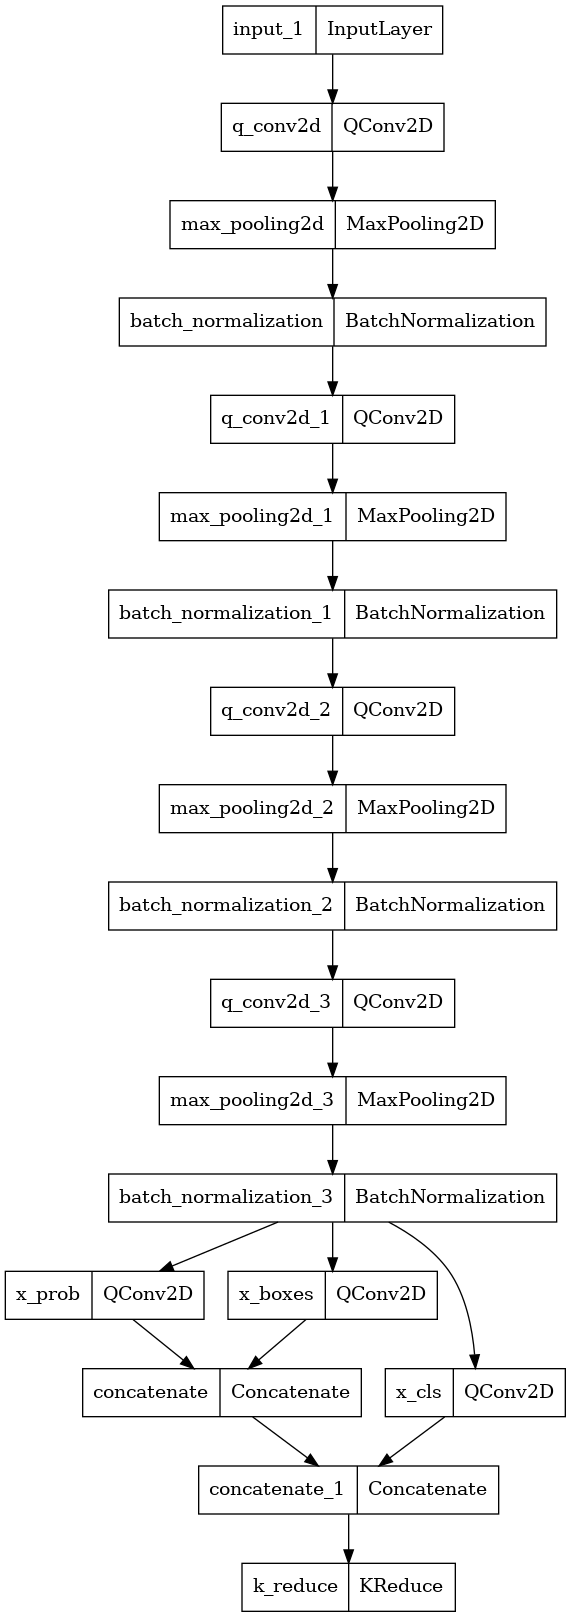

In [20]:
 tf.keras.utils.plot_model(model_reduce)

## Post-training quantization, compiling an hls4ml model

Here we will compile the HLS representation of our model with the custom layer. Notice we set the output precision to 31 bits as previously described. Weight and result precisions were determined by analyzing the model profiling plots found in the next section.

In [21]:
def print_dict(d, indent=0):
    """
    Prints dictionary to view hls4ml model config
    
    :param d: dictionary
    :param intend: indentation
    """

    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value)) 

In [22]:
config = hls4ml.utils.config_from_keras_model (model_reduce,
                                                   default_precision = 'ap_fixed<32,16>',
                                                   granularity = 'name')


io_type = 'io_stream'
backend = 'Vitis'
part = 'xcku035-fbva676-2-e'
strategy = 'Resource'
tracing = True
rf = 1
OUT_DIR = f'folo_on_frame_grabber'

config['IOType'] = io_type
config['backend'] = backend
config['XilinxPart'] = part
config["Model"]["Strategy"] = strategy
config["Model"]["ReuseFactor"] = rf
for layer in config["LayerName"]:
    config["LayerName"][layer]["Trace"] = tracing

# Post scaling input datatype. We will only ever have uint inputs normalized from 0 to 1. If you use another method, you may need to change this type.
config["LayerName"]["input_1"]["Precision"]["result"] = "ap_ufixed<16,1>" 

config["LayerName"]["q_conv2d"]['ReuseFactor'] = 3
config["LayerName"]["q_conv2d"]["Strategy"] = "Resource"
config["LayerName"]["q_conv2d"]["Precision"]["weight"] = "ap_fixed<16,4>"
config["LayerName"]["q_conv2d"]["Precision"]["bias"] = "ap_fixed<8,3>"
config["LayerName"]["q_conv2d"]["Precision"]["result"] = "ap_fixed<17,5>"

config["LayerName"]["q_conv2d_relu"]["Precision"]["result"] = "ap_ufixed<16,4>"

config["LayerName"]["max_pooling2d"]["Precision"]["result"] = "ap_ufixed<16,4>"

config["LayerName"]["batch_normalization"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["q_conv2d_1"]['ReuseFactor'] = 36
config["LayerName"]["q_conv2d_1"]["Strategy"] = "Resource"
config["LayerName"]["q_conv2d_1"]["Precision"]["weight"] = "ap_fixed<18,5>"
config["LayerName"]["q_conv2d_1"]["Precision"]["bias"] = "ap_fixed<15,4>"
config["LayerName"]["q_conv2d_1"]["Precision"]["result"] = "ap_fixed<16,11>"

config["LayerName"]["q_conv2d_1_relu"]["Precision"]["result"] = "ap_ufixed<16,10>"

config["LayerName"]["max_pooling2d_1"]["Precision"]["result"] = "ap_ufixed<16,10>"

config["LayerName"]["batch_normalization_1"]["Precision"]["result"] = "ap_fixed<16,8>"

config["LayerName"]["q_conv2d_2"]['ReuseFactor'] = 144
config["LayerName"]["q_conv2d_2"]["Strategy"] = "Resource"
config["LayerName"]["q_conv2d_2"]["Precision"]["weight"] = "ap_fixed<16,3>"
config["LayerName"]["q_conv2d_2"]["Precision"]["bias"] = "ap_fixed<9,2>"
config["LayerName"]["q_conv2d_2"]["Precision"]["result"] = "ap_fixed<16,11>"

config["LayerName"]["q_conv2d_2_relu"]["Precision"]["result"] = "ap_ufixed<16,10>"

config["LayerName"]["max_pooling2d_2"]["Precision"]["result"] = "ap_ufixed<16,10>"

config["LayerName"]["batch_normalization_2"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["q_conv2d_3"]['ReuseFactor'] = 576
config["LayerName"]["q_conv2d_3"]["Strategy"] = "Resource"
config["LayerName"]["q_conv2d_3"]["Precision"]["weight"] = "ap_fixed<18,5>"
config["LayerName"]["q_conv2d_3"]["Precision"]["bias"] = "ap_fixed<12,5>"
config["LayerName"]["q_conv2d_3"]["Precision"]["result"] = "ap_fixed<16,12>"

config["LayerName"]["q_conv2d_3_relu"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["max_pooling2d_3"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["batch_normalization_3"]["Precision"]["result"] = "ap_fixed<16,4>"

config["LayerName"]["x_prob"]['ReuseFactor'] = 144
config["LayerName"]["x_prob"]["Strategy"] = "Resource"
config["LayerName"]["x_prob"]["Precision"]["weight"] = "ap_fixed<13,3>"
config["LayerName"]["x_prob"]["Precision"]["bias"] = "ap_fixed<5,3>"
config["LayerName"]["x_prob"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["x_prob_sigmoid"]["Precision"]["result"] = "ap_ufixed<16,0>"

config["LayerName"]["x_boxes"]['ReuseFactor'] = 576
config["LayerName"]["x_boxes"]["Strategy"] = "Resource"
config["LayerName"]["x_boxes"]["Precision"]["weight"] = "ap_fixed<19,5>"
config["LayerName"]["x_boxes"]["Precision"]["bias"] = "ap_fixed<7,5>"
config["LayerName"]["x_boxes"]["Precision"]["result"] = "ap_fixed<16,7>"

config["LayerName"]["x_boxes_linear"]["Precision"]["result"] = "ap_fixed<16,7>"

config["LayerName"]["concatenate"]["Precision"]["result"] = "ap_fixed<16,7>"


config["LayerName"]["x_cls"]['ReuseFactor'] = 1440 
config["LayerName"]["x_cls"]["Strategy"] = "Resource"
config["LayerName"]["x_cls"]["Precision"]["weight"] = "ap_fixed<21,5>"
config["LayerName"]["x_cls"]["Precision"]["bias"] = "ap_fixed<7,3>"
config["LayerName"]["x_cls"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["x_cls_sigmoid"]["Precision"]["result"] = "ap_ufixed<16,0>"

config["LayerName"]["concatenate_1"]["Precision"]["result"] = "ap_fixed<16,7>"

config["LayerName"]["k_reduce"]["Precision"]["result"] = "ap_uint<31>"

print_dict(config)
    

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 48, 128, 16]], output shape: [None, 24, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 12, 32, 16]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]

In [23]:
# optimized_model = optimize_keras_model_for_hls4ml(
#     model, config, VivadoDSPEstimator, scheduler,
#     X_train, y_train, X_val, y_val, batch_size, pr_epochs,
#     opt, loss_func, metric, increasing, rtol
# )

In [24]:
# optimized_model.save_weights('weights/folo_weights_qat_pruned.h5')

In [25]:
# keras_y_pred = optimized_model.predict(X_test[0:100])
# show_predict(X_test[0], keras_y_pred[0], threshold=threshold)

In [26]:
# keras_y_pred_ex, y_ex = eval_model_cls_performance(keras_y_pred, y_test[0:100])
# FOLO_accuracy_keras = np.mean(keras_y_pred_ex == y_ex) * 100
# print(f'Pruned FOLO classification accuracy on subset: {FOLO_accuracy_keras:.2f}%')

In [27]:
# sparsity, layers = get_model_sparsity(optimized_model)
# print(f'Optimized Keras sparsity, overall: {sparsity}')
# print(f'Opimized Keras sparsity, per-layer: {layers}')

In [28]:
model_reduce.load_weights('weights/folo_weights_qat_pruned.h5')

In [29]:
hls_model = hls4ml.converters.convert_from_keras_model(model_reduce,
                                                       hls_config = config,
                                                       io_type = io_type,
                                                       backend = backend,
                                                       output_dir = OUT_DIR,
                                                       part = part
                                                       )

hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 48, 128, 16]], output shape: [None, 24, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 12, 32, 16]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]

Done


## HLS model profiling

Now we will take a look two very useful types of plots. The first is to compare the precision ranges of our model weights to the precision of the HLS model's fixed-point precision weight and result types. The second compares the model outputs of our HLS model to the QKeras model. We will disregard the ``reduce`` layer output since our QKeras model does not implement that layer. These plots give us a sense of what precisions we should set for each layer to optimize across accuracy and resources. We can tell how closely we've matched the floating point model by looking at the output layer plot (or in this case second to last), ```concatenate_1```.

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 48, 128, 16]], output shape: [None, 24, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 12, 32, 16]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]

Done
   q_conv2d
   q_conv2d_relu
   max_pooling2d
   batch_normalization
   q_conv2d_1
   q_conv2d_1_relu
   max_pooling2d_1
   batch_normalization_1
   q_conv2d_2
   q_conv2d_2_relu
   max_pooling2d_2
   batch_normalization_2
   q_conv2d_3
   q_conv2d_3_relu
   max_pooling2d_3
   batch_normalization_3
   x_prob
   x_prob_sigmoid
   x_boxes
   concatenate
   x_cls
   x_cls_sigmoid
   concatenate_1
   k_reduce


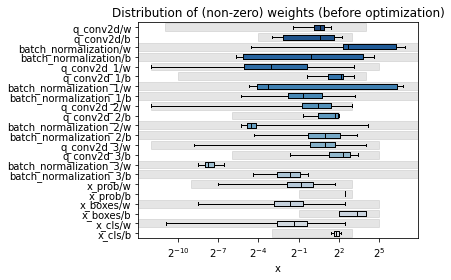

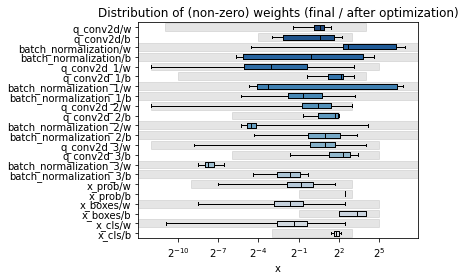

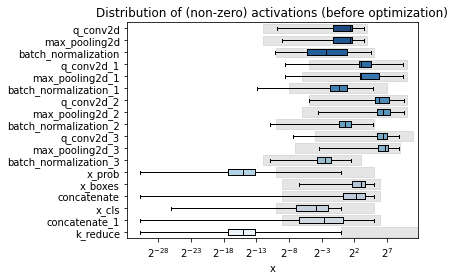

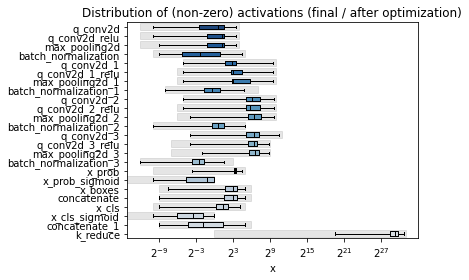

In [30]:
# Compare weights ranges between float and HLS model
X_profile, y_profile = make_data(size=10)
%matplotlib inline
plots = hls4ml.model.profiling.numerical(model=model_reduce, hls_model = hls_model, X=np.ascontiguousarray(X_profile))

Done taking outputs for Keras model.
Recompiling myproject with tracing
Writing HLS project


Done


/tmp/ipykernel_1830844/1309788270.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


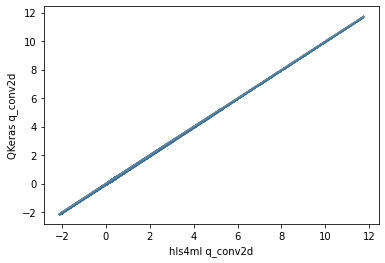

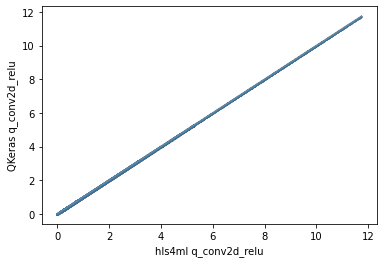

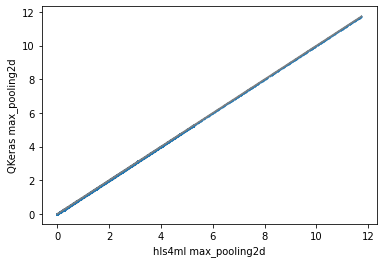

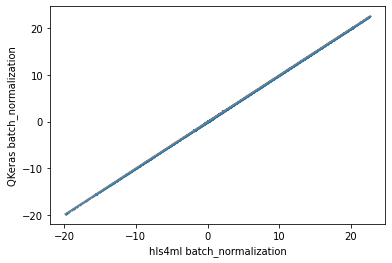

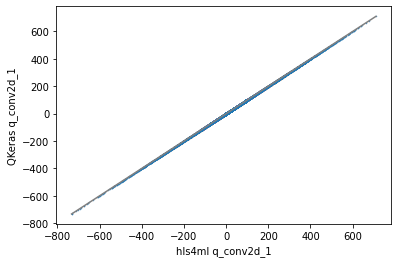

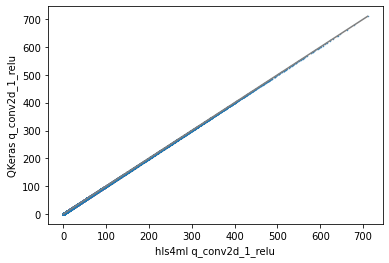

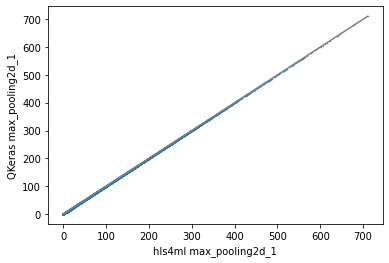

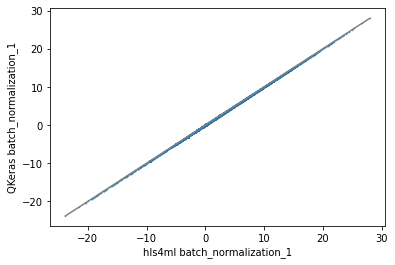

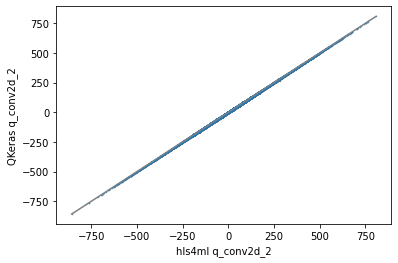

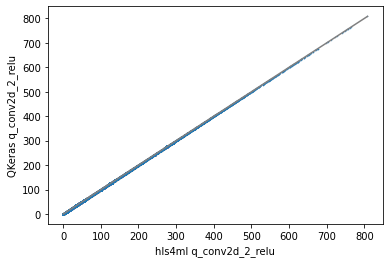

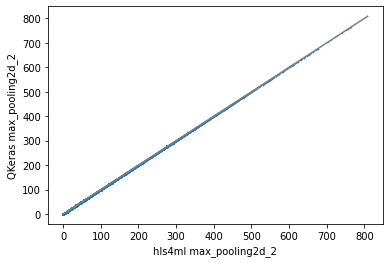

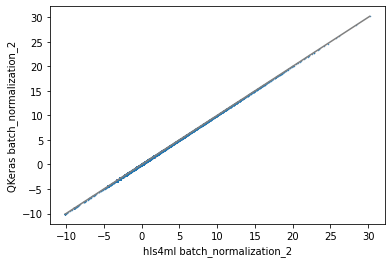

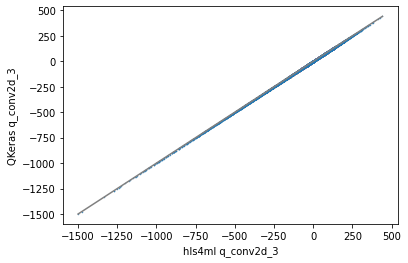

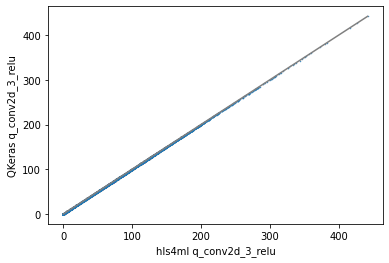

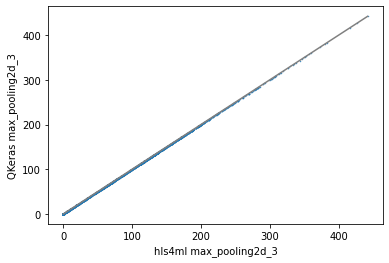

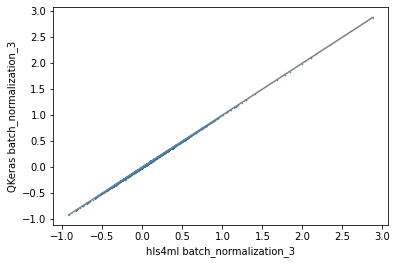

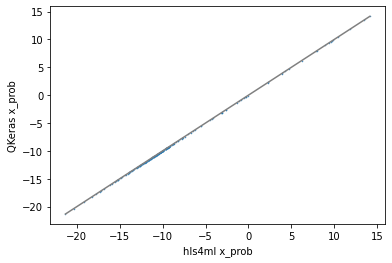

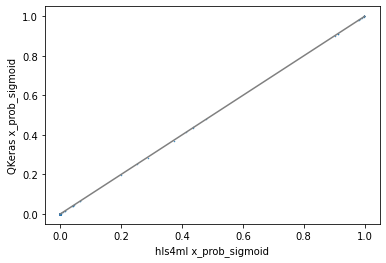

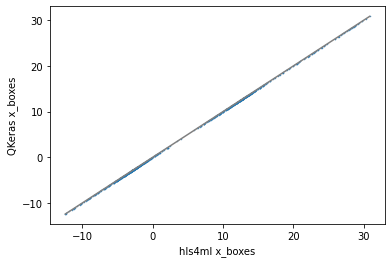

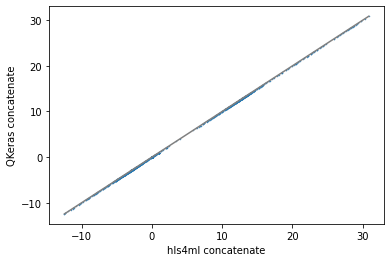

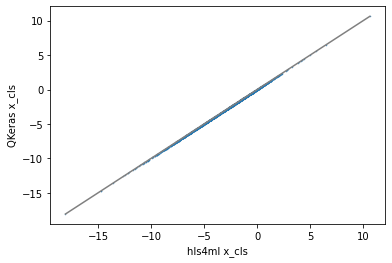

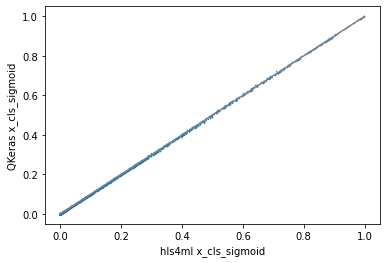

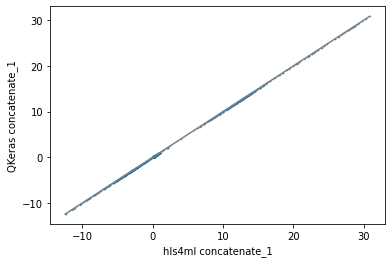

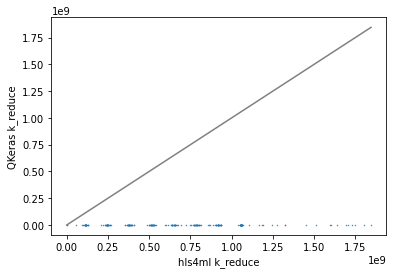

In [31]:
# Trace Model
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model_reduce, np.ascontiguousarray(X_profile))
y_hls, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X_profile))

# Compare layer outputs
for layer in hls4ml_trace.keys():
            plt.figure()
            klayer = layer
            if "_alpha" in layer:
                klayer = layer.replace("_alpha", "")
            if "_linear" in layer:
                klayer = layer.replace("_linear", "")
            plt.scatter(hls4ml_trace[layer].flatten(), keras_trace[klayer].flatten(), s=0.2)
            min_x = min(np.amin(hls4ml_trace[layer]), np.amin(keras_trace[klayer]))
            max_x = max(np.amax(hls4ml_trace[layer]), np.amax(keras_trace[klayer]))
            plt.plot([min_x, max_x], [min_x, max_x], c="gray")
            plt.xlabel("hls4ml {}".format(layer))
            plt.ylabel("QKeras {}".format(klayer))

## Simulate HLS model

Before we integrate our neural network into the frame grabber reference design. Lets make sure it's providing solid results by running csim. We will need to save a subset of our test data to the testbennch directory.

In [32]:
np.savetxt(f"{OUT_DIR}/tb_data/tb_input_features.dat", X_test[0:100].reshape(X_test[0:100].shape[0], -1), delimiter=' ')
np.savetxt(f"{OUT_DIR}/tb_data/tb_output_predictions.dat", np.zeros(y_test[0:100].shape[0:3]).reshape(y_test[0:100].shape[0], -1), delimiter=' ') # no need to save true y's since we have to parse bitstring outputs

In [ ]:
hls_model.build(csim=True, synth=False, cosim=False, validation=False, vsynth=False, export=False)

In [34]:
hls_predictions = np.genfromtxt(f"{OUT_DIR}/tb_data/csim_results.log", delimiter=' ')

In [35]:
def bit_range(num, end_idx, start_idx):
    """
    Extracts bit range from integer
    
    :param num: Number from which to extract bits
    :param end_idx: Ending index (inclusive) from the right in the binary representation
    :param start_idx: Starting index (inclusive) from the right in the binary representation
    :return: Extracted bit range as an integer
    """
    
    mask = ((1 << (end_idx + 1)) - 1) - ((1 << start_idx) - 1)
    return (num & mask) >> start_idx

def one_hot_encode(digit):
    """
    One-hot encode a digit into a 10-element vector.
    
    :param digit: Digit to encode
    :return: encoding
    """
    
    encoding = np.zeros(10, dtype=int)
    encoding[digit] = 1
    return encoding

def show_predict_hardware(X, y):
    """
    Display single prediction results from the hardware (parsed from the output bit strings)
    
    :param X: Data sample input
    :param y: Model predictions
    """
    
    X = X.copy()
    channels = np.zeros((6), dtype=np.uint64)
    
    for i in range(24):
        channels[0] = bit_range(int(y[i]), 30, 30)
        channels[1] = bit_range(int(y[i]), 29, 23)
        channels[2] = bit_range(int(y[i]), 22, 17)
        channels[3] = bit_range(int(y[i]), 16, 10)
        channels[4] = bit_range(int(y[i]), 9, 4)
        channels[5] = bit_range(int(y[i]), 3, 0)
        
        if channels[0] < 1:
            continue

        color = 255
        # bounding box
        cv2.rectangle(X, (channels[1], channels[2]), (channels[3], channels[4]), -1, 1)

        print("digit: " + str(channels[5]) + ", prob: " + str(channels[0]) + ", x1: " + str(int(channels[1])) + ", y1: " + str(int(channels[2])) + ", x2: " + str(int(channels[3])) + ", y2: " + str(int(channels[4])))

        # label
        cv2.rectangle(X, (int(channels[1]), int(channels[2]-10)), (int(channels[1]+12), int(channels[2])), -1, -1)
        kls = channels[5]
        cv2.putText(X, f'{kls}', (int(channels[1]+2), int(channels[2]-2)), cv2.FONT_HERSHEY_PLAIN, 0.7, (0.0, 0.0, 0.0))

    plt.imshow(X, cmap="gray")

    
def eval_model_cls_performance(y_pred, y):
    """
    Evaluate models class performance
    
    :param y_pred: model predictions 
    :param y: true y
    :return predicted_labels_y_pred: y predicted
    :return predicted_labels_y: y label
    """
    
    y_pred_flattened = y_pred.reshape(-1, 15)
    filtered_indices = y_pred_flattened[:, 0] > threshold
    filtered_y_pred = y_pred_flattened[filtered_indices]
    filtered_y = y.reshape(-1, 15)[filtered_indices]

    predicted_labels_y_pred = np.argmax(filtered_y_pred[:, 5:15], axis=1)
    predicted_labels_y = np.argmax(filtered_y[:, 5:15], axis=1)

    return predicted_labels_y_pred, predicted_labels_y    
    
def create_FOLO_output_from_hardware(input_array):
    """
    Decode FOLO output from hardware
    
    :param input_array: FOLO hardware output 
    :return output_array: decoded FOLO output
    """
    
    output_array = np.zeros((input_array.shape[0]*input_array.shape[1], 15), dtype=int)
    
    idx = 0
    for i in range(input_array.shape[0]):
        for j in range(input_array.shape[1]):
            # First feature: just the first bit
            output_array[idx, 0] = bit_range(int(input_array[i, j]), 30, 30)

            # Subsequent bit ranges
            output_array[idx, 1] = bit_range(int(input_array[i, j]), 29, 23)
            output_array[idx, 2] = bit_range(int(input_array[i, j]), 22, 17)
            output_array[idx, 3] = bit_range(int(input_array[i, j]), 16, 10)
            output_array[idx, 4] = bit_range(int(input_array[i, j]), 9, 4)

            # One hot encoding for MNIST digits
            digit = bit_range(int(input_array[i, j]), 3, 0)
            output_array[idx, 5:15] = one_hot_encode(digit)

            idx += 1
    
    return output_array

digit: 6, prob: 1, x1: 52, y1: 12, x2: 76, y2: 35
digit: 6, prob: 1, x1: 24, y1: 20, x2: 49, y2: 44


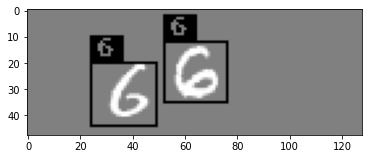

In [36]:
show_predict_hardware(X_test[0], hls_predictions[0])

### HLS model classification performance

In [37]:
hls_y_pred = create_FOLO_output_from_hardware(hls_predictions)

In [38]:
hls_y_pred_ex, y_ex = eval_model_cls_performance(hls_y_pred, y_test[0:100])
FOLO_accuracy_hls = np.mean(hls_y_pred_ex == y_ex) * 100
print(f'FOLO hls classification accuracy on subset: {FOLO_accuracy_hls:.2f}%')

FOLO hls classification accuracy on subset: 81.94%


## FIFO Optimization

Now we will run a fifo optimization. This process will optimize the depths of the FIFOs used to connect one layer to the next and will save tremendously on BRAM resources. Note that this process requires that we recompile our HLS model which will run c-simulation, c synthesis, and RTL simulation. This process is automated but can take some time. The HLS will automatically be updated with the new FIFO depths.

In [39]:
config['Flows'] = ['vitis:fifo_depth_optimization']
hls4ml.model.optimizer.get_optimizer('vitis:fifo_depth_optimization').configure(profiling_fifo_depth=6_500)

We don't want the FIFO optimization to take to long so let's save only three samples to the testbench

In [40]:
np.savetxt(f"{OUT_DIR}/tb_data/tb_input_features.dat", X_test.reshape(X_test.shape[0], -1)[0:3], delimiter=' ')
np.savetxt(f"{OUT_DIR}/tb_data/tb_output_predictions.dat", np.zeros(y_test.shape[0:3]).reshape(y_test.shape[0], -1)[0:3], delimiter=' ') # no need to save true y's since we have to parse bitstring outputs

In [ ]:
hls_model = hls4ml.converters.convert_from_keras_model(model_reduce,
                                                       hls_config = config,
                                                       io_type = 'io_stream',
                                                       output_dir = OUT_DIR,
                                                       backend = "Vitis",
                                                       part='xcku035-fbva676-2-e'
                                                       )

hls_model.compile()

## Frame grabber firmware integration

Now let's begin merging our hls4ml project with the frame grabber reference design. The reference design will embed the model predictions in the first n bits of the corresponding frame where n is the total size of a single model inference output. We only need to copy a few files and portions of the HLS over to the refrerence design ``FRAME_GRABBER_DIR``.

First let's reference the correct design files for the board we're targetting. Set ``board`` to "octo", "quad", or "qsfp". For this step, **place your zipped CustomLogic package in the same directory as this repository. Change your target board and CustomLogic download destination directory in the cell below if needed.** 

**Important**: Custom versions of the stock ```CustomLogic.vhd```, ```create_vivado_project.tcl```, and ```customlogic_functions.tcl``` files are used for this tutorial and are stored in this repository. Future updates to CustomLogic may render these files obsolete. In this case, **do not** contact Euresys for support. Instead, feel free to contact the email at the end of notebook for support.  

In [42]:
BOARD = "octo" # Insert board name here ("octo" or "quad" or "qsfp")
CUSTOMLOGIC_DOWNLOAD_DIR = ".." # Place your CustomLogic zip download in the same directory as this repository.
FRAME_GRABBER_DIR = f"my-frame-grabber_TEMPLATE_FOLO_{BOARD.lower()}"

In [43]:
import os
import shutil
import glob

# Check for CustomLogic downloads
customlogic_files = glob.glob(f"{CUSTOMLOGIC_DOWNLOAD_DIR}/coaxlink-customlogic-*.zip")
if not customlogic_files:
    raise FileNotFoundError("Error: No CustomLogic downloads found")
else:
    valid_files = []
    for file in customlogic_files:
        base_name = os.path.basename(file)
        version_no = base_name[len("coaxlink-customlogic-"):].split('.')[0] 

        # Check version number
        if version_no.isdigit() and int(version_no) >= 24:
            valid_files.append(file)

    if len(valid_files) > 1:
        raise ValueError("Error: More than one CustomLogic download found. Please ensure only one CustomLogic download exists in the target directory.")    
    elif not valid_files:
        raise ValueError("Error: Your CustomLogic download is too old or another error occurred. Ensure you have CustomLogic version 24 or higher.")

In [ ]:
!unzip -o {valid_files[0]} -d ..

In [45]:
def get_camera_model(board_type):
    board_to_model = {
        'octo': 'CoaxlinkOcto_1cam',
        'quad': 'CoaxlinkQuadCxp12_1cam',
        'qsfp': 'CoaxlinkQsfp_1cam'
    }

    if board_type in board_to_model:
        return board_to_model[board_type]
    else:
        raise ValueError(f"Error: please specify one of the following boards: \"octo\", \"quad\", \"qsfp\"")
    
target_frame_grabber = get_camera_model(BOARD)

os.makedirs(FRAME_GRABBER_DIR, exist_ok=True)

# CustomLogic required files
shutil.copytree(f"../CustomLogic/{target_frame_grabber}/01_readme", f"{FRAME_GRABBER_DIR}/01_readme", dirs_exist_ok=True)
shutil.copytree(f"../CustomLogic/{target_frame_grabber}/02_coaxlink", f"{FRAME_GRABBER_DIR}/02_coaxlink", dirs_exist_ok=True)
shutil.copytree(f"../CustomLogic/{target_frame_grabber}/03_scripts", f"{FRAME_GRABBER_DIR}/03_scripts", dirs_exist_ok=True)
shutil.copytree(f"../CustomLogic/{target_frame_grabber}/04_ref_design", f"{FRAME_GRABBER_DIR}/04_ref_design", dirs_exist_ok=True)
shutil.copytree(f"../CustomLogic/{target_frame_grabber}/06_release", f"{FRAME_GRABBER_DIR}/06_release", dirs_exist_ok=True)

# Required scripts
shutil.copy(f"board_files/{BOARD.lower()}/run_impl.tcl", f"{FRAME_GRABBER_DIR}/03_scripts")
shutil.copy(f"board_files/{BOARD.lower()}/create_vivado_project.tcl", f"{FRAME_GRABBER_DIR}/03_scripts")
shutil.copy(f"board_files/customlogic_functions.tcl", f"{FRAME_GRABBER_DIR}/03_scripts")

# Required design files
shutil.copy(f"board_files/CustomLogic.vhd", f"{FRAME_GRABBER_DIR}/04_ref_design")
shutil.copy(f"board_files/myproject_axi_wrp.vhd", f"{FRAME_GRABBER_DIR}/04_ref_design")
shutil.copy(f"board_files/result_writeout.v", f"{FRAME_GRABBER_DIR}/04_ref_design")
shutil.copy(f"board_files/signal_inference.v", f"{FRAME_GRABBER_DIR}/04_ref_design")

# Required HLS design files
shutil.copytree(f"board_files/05_model_design_hls", f"{FRAME_GRABBER_DIR}/05_model_design_hls", dirs_exist_ok=True)
shutil.copy(f"board_files/{BOARD.lower()}/CustomLogic.h", f"{FRAME_GRABBER_DIR}/05_model_design_hls/srcs")

Now lets copy some files over from our hls4ml project to the reference design. You may reference your own hls4ml project rather than this FOLO example to deploy your own model.

In [46]:
!cp -r {OUT_DIR}/firmware/nnet_utils {OUT_DIR}/firmware/weights {OUT_DIR}/firmware/ap_types {OUT_DIR}/firmware/parameters.h {OUT_DIR}/firmware/defines.h {FRAME_GRABBER_DIR}/05_model_design_hls/srcs

### Acquisition parameters, network weights, layers, and other

Firstly, lets define some of the acquisition parameters in ``CustomLogic.h``. These parameters include
- ``PIXEL_FORMAT``: Specify your pixel format. Valid values are 8 or 16. If you are recording in 12-bit, write 16 here.
- ``NORM_DIV``: Divide your model's input data by this value for normailzation. In this example we will divide by 255 because we will be recording in Mono8 format.
- ``IMAGE_WIDTH``: Acuisition image width.
- ``IMAGE_HEIGHT``: Acuisition image height.
- ``CROP_START_X``: If you would like to crop the image input to a specific ROI, specify the start x coordinate here. If you do not wish to crop an ROI, set this to 0.
- ``CROP_START_Y``: Specify the crop start y coordinate here. If you do not wish to crop an ROI, set this to 0.
- ``CROP_WIDTH``: Specify the crop width. If you do not wish to crop an ROI, set this equal to the IMAGE_WIDTH.
- ``CROP_HEIGHT``: Specify the crop height. If you do not wish to crop an ROI, set this equal to the IMAGE_HEIGHT.
- ``BLOCK_HEIGHT``: This parameter must be copied from the eGrabber interface. It will be auto-populated and can be found under Data Stream > StreamControl > BlockHeight. Enter it here.

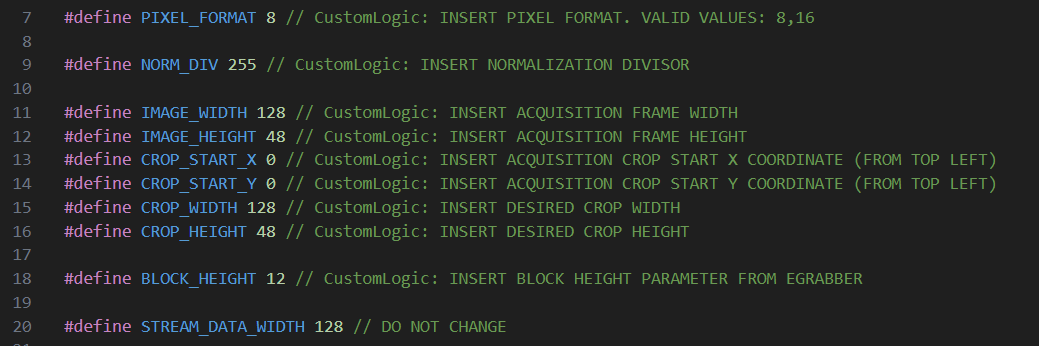

Now, at the bottom of ``CustomLogic.h`` we must enter the striping pattern which the frame grabber will receive out of the camera so the firmware can reoder the data before streaming into the model. Run the cell below to calculate the correct order. You will need to provide your image height and block height.

In [1]:
IMAGE_HEIGHT = 48
BLOCK_HEIGHT = 12

def gen_stripe_pattern(NUM_STRIPES):
    if NUM_STRIPES % 2 != 0:
        print("NUM_STRIPES must be even")
        return None
    
    stripe_order = []
    for i in range(NUM_STRIPES):
        if i % 2 == 0:
            stripe_order.append(((NUM_STRIPES // 2) - (i // 2)) - 1)
        else:
            stripe_order.append(((NUM_STRIPES // 2) + ((i + 1) // 2)) - 1)
    
    return stripe_order

NUM_STRIPES = IMAGE_HEIGHT/(BLOCK_HEIGHT/2)
stripe_order = str(gen_stripe_pattern(int(NUM_STRIPES))).replace('[', '{').replace(']', '}')
print("Copy this array to the strip_order constant in CustomLogic.h: ", stripe_order)

Copy this array to the strip_order constant in CustomLogic.h:  {3, 4, 2, 5, 1, 6, 0, 7}



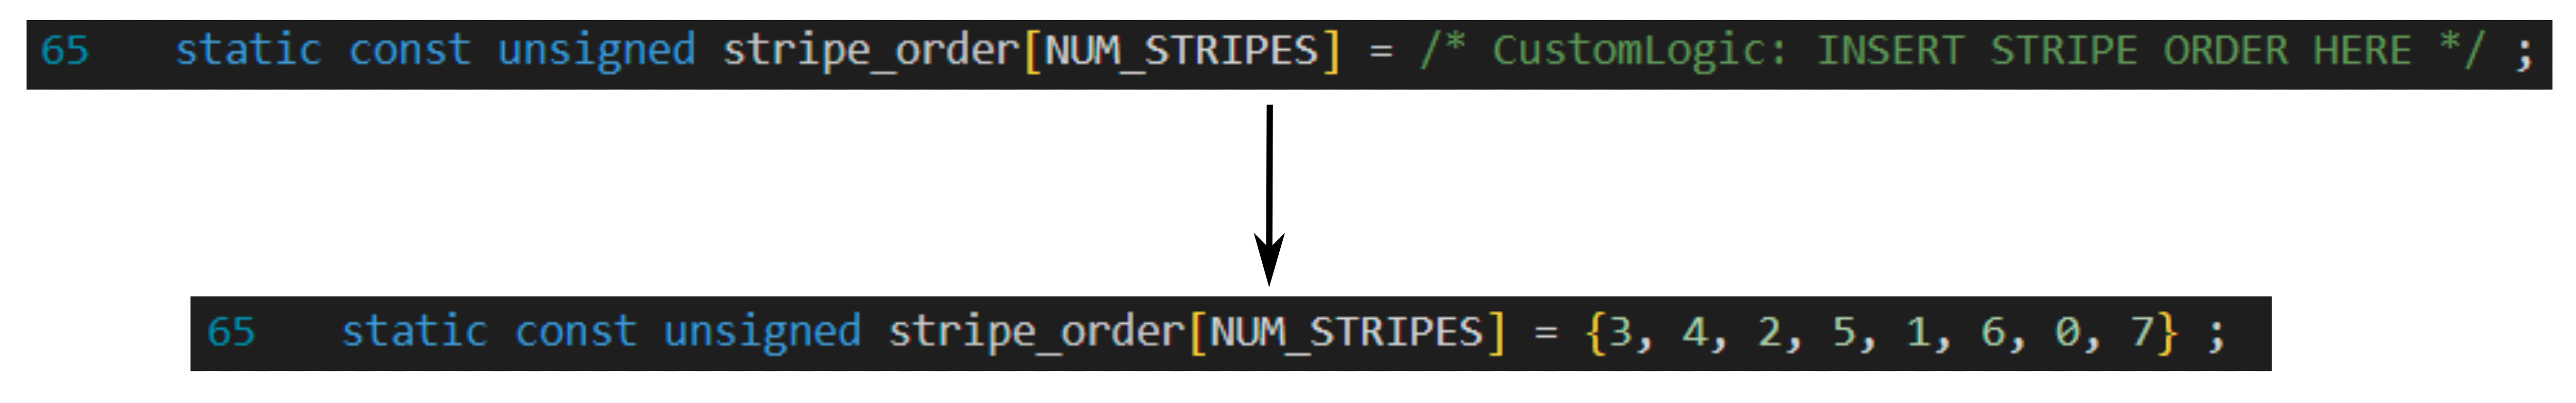

Now we'll begin copying over some HLS from your hls4ml project to the frame grabber template project.

First, set the value of ``MODEL_OUT_DEPTH`` to the depth of your model's output stream. For this FOLO model, we know the output stream will have a depth of 1×8×3=24 based on the shape of our ouput data.

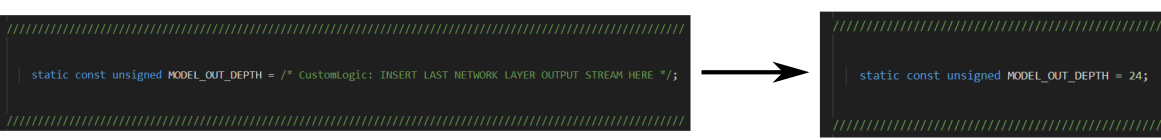

Next, copy your weight import statements to ``myproject.cpp``to the position shown below.

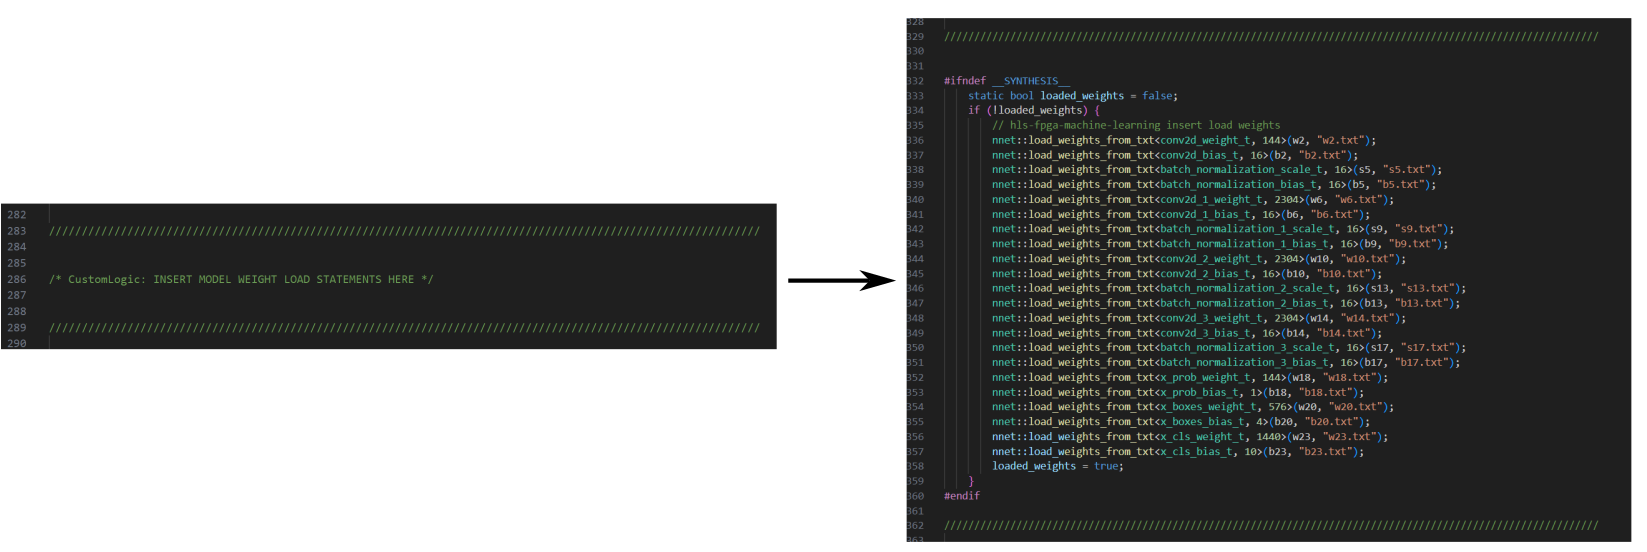

Next, we need to set the depths of the intermediate split input streams ``input_arr_split_reordered`` which reorder the frame input to natural order. Use the output of the cell below.


In [3]:
def generate_pragma_lines(NUM_STRIPES):
    for i in range(NUM_STRIPES):
        print(f'    #pragma HLS STREAM variable=input_arr_split_reordered[{i}] depth=PACKETS_PER_STRIPE')

generate_pragma_lines(int(NUM_STRIPES))

print("\n\nCopy the above HLS to myproject.cpp in the appropriate location as shown below.")

    #pragma HLS STREAM variable=input_arr_split_reordered[0] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[1] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[2] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[3] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[4] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[5] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[6] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[7] depth=PACKETS_PER_STRIPE


Copy the above HLS to myproject.cpp in the appropriate location as shown below.


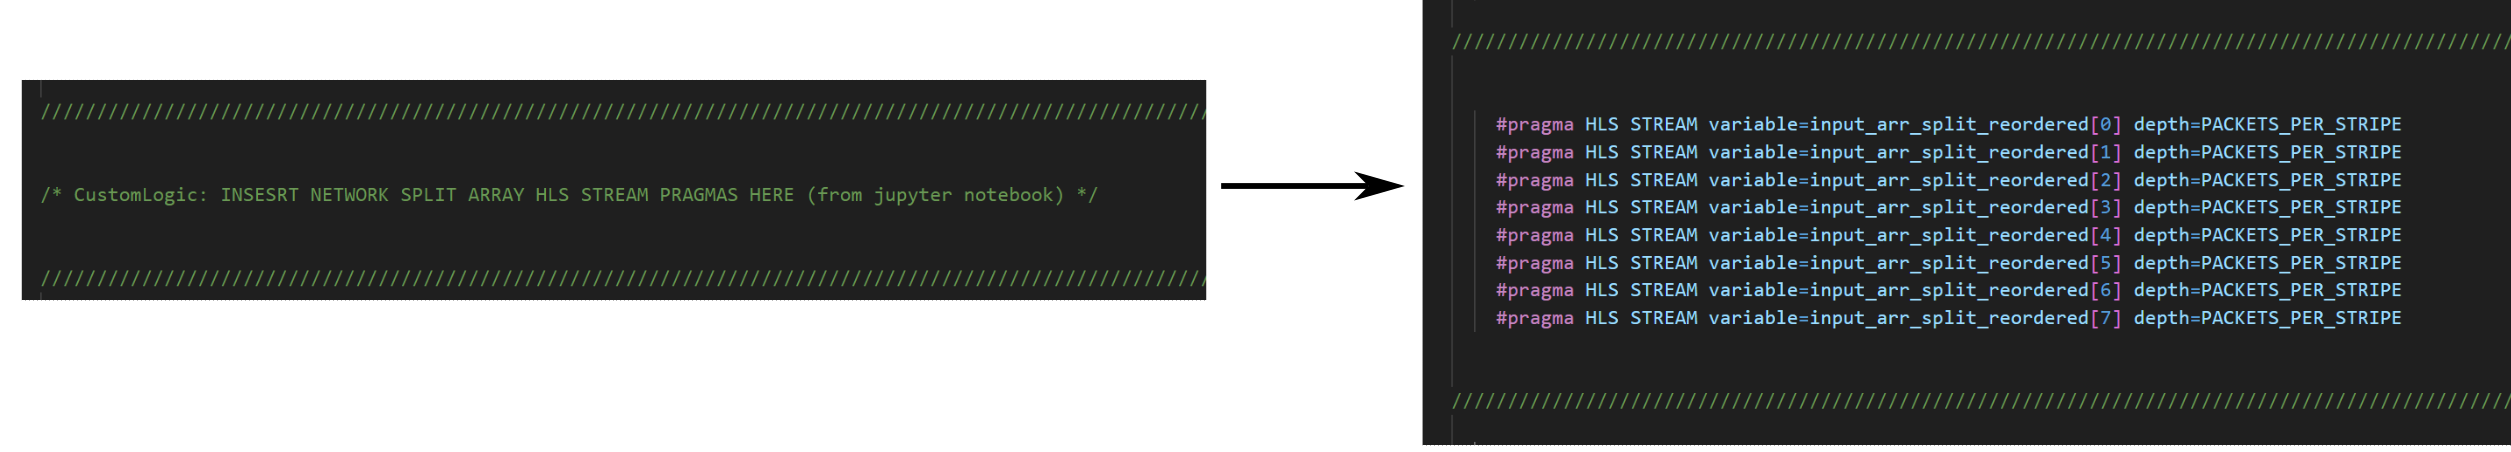

Next, let's copy over the model layers (truncated for viewing, yours may have ``save_layer_output()`` statements interleaved.

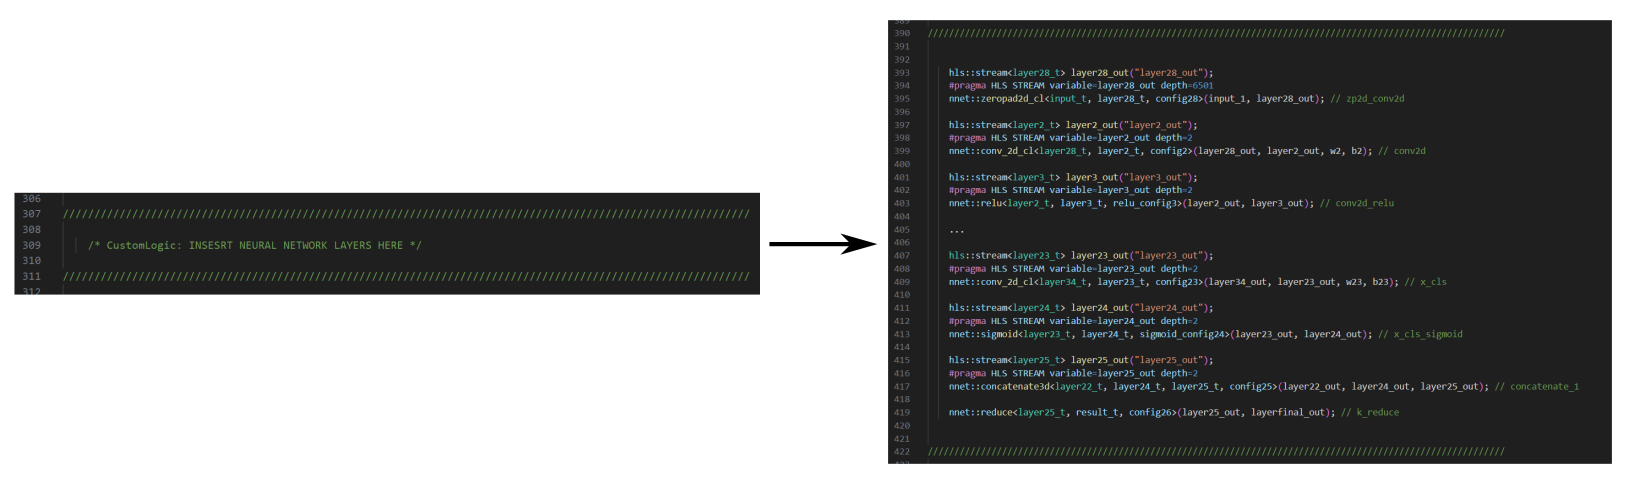

Lastly, we will need to change the name of the model output stream (``layer26_out`` in this case) to ``layerfinal_out``. Your model output stream should be the last stream argument of your networks final layer. ``attach_results()`` will then insert the neural network predictions at the beginning of the image.

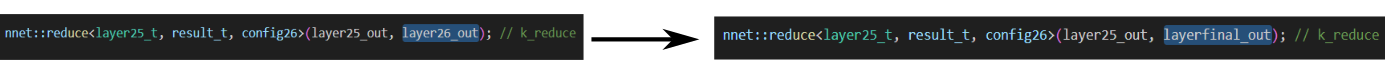

Now, in ``defines.h``, we have to add one include statement, ``#include "CustomLogic.h"``, at the top and one new type definition, ``typedef nnet::array<input_t::value_type, MONOPIX_NBR> input_arr_t;``

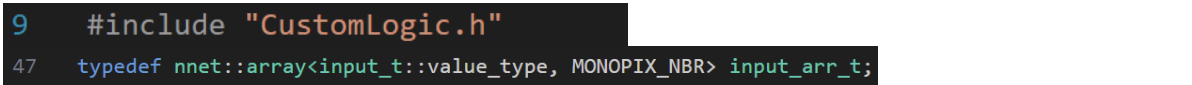

### C-simulation

Just like last time, lets save a small dataset to validate our frame grabber firmware with our QKeras model via c-simulation.

In [47]:
np.savetxt(f"{FRAME_GRABBER_DIR}/05_model_design_hls/tb_data/tb_input_features.dat", X_test.reshape(X_test.shape[0], -1)*255.0, delimiter=' ', fmt='%d')
np.savetxt(f"{FRAME_GRABBER_DIR}/05_model_design_hls/tb_data/tb_output_predictions.dat", np.zeros(y_test.shape[0:3]).reshape(y_test.shape[0], -1), delimiter=' ')

Now we can execute c-simulation to ensure our frame grabber firmware is producing the expected results

In [ ]:
!vitis_hls {FRAME_GRABBER_DIR}/05_model_design_hls/scripts/run_hls.tcl -f "csim=1 synth=0"

digit: 6, prob: 1, x1: 52, y1: 12, x2: 76, y2: 35
digit: 6, prob: 1, x1: 24, y1: 20, x2: 49, y2: 44


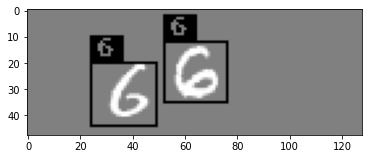

In [49]:
csim_predictions = np.genfromtxt(f"{FRAME_GRABBER_DIR}/05_model_design_hls/tb_data/csim_results.log", delimiter=' ')
show_predict_hardware(X_test[0], csim_predictions[0])

### Frame grabber model classification performance

In [50]:
csim_y_pred = create_FOLO_output_from_hardware(csim_predictions)

In [51]:
csim_y_pred_ex, y_ex = eval_model_cls_performance(csim_y_pred, y_test[0:100])
FOLO_accuracy_csim = np.mean(csim_y_pred_ex == y_ex) * 100
print(f'FOLO csim classification accuracy: {FOLO_accuracy_csim:.2f}%')

FOLO csim classification accuracy: 81.94%


### C-synthesis

Now run c-synthesis to generate the RTL representation of our design

In [ ]:
!vitis_hls {FRAME_GRABBER_DIR}/05_model_design_hls/scripts/run_hls.tcl -f "csim=0 synth=1"

### Implementation

Run logic synthesis and place & route. The runtime can be quite long so we recommend executing the following in a command line rather than through this notebok. We use ``nohup`` for no hang up and ``&`` to put it in the background. After changing your directory to ```FRAME_GRABBER_DIR``` run

```bash
nohup vivado -mode tcl -source 03_scripts/run_impl.tcl &
```

### Optional: Benchmarking

RTL is written in to mark the start and completion of your model inference. Follow the steps below to measure latency

1. In eGrabber Studio (or GenICam), locate the ``DigitalIOControl`` and ``LineSource`` sections
2. Assign ``TTLIO11`` to bit 0 of the user output register (``UserOutput0``)
3. Under the ``DigitalIOControl`` section, select ``TTLIO11`` in the ``LineSelector`` field
4. Set the ``LineMode`` to ``Output``
5. Under the ``LineSource`` section, select ``UserOutput0``
6. Connect an oscilloscope or other digitizer to ``TTLIO11`` (pin 19 of  Internal I/0 1 Connector, see [here](https://documentation.euresys.com/Products/Coaxlink/Coaxlink_10_5/en-us/Content/03_Using_Coaxlink/hardware-manual/meca/connectors/inst300-int-io1.htm?tocpath=Using%20Coaxlink%7CHardware%20Manual%7CMechanical%20Specification%7CConnectors%7C_____15)).

Begin acquisition at a lower frame rate to start. The high-time you observe is your model's latency.

## Conclusion

Please feel free to reach out with feedback or questions at forelliryan@gmail.com.